# **Monte Carlo Neuron Simulation**

**Import Statements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
from matplotlib.colors import ListedColormap
import scipy.io

#loading input channel data with x, y coordinates of the electrodes and their 5RMS thresholds in microvolts [uV]
channels = scipy.io.loadmat("channels.mat")
RMS_threshold = channels["channels"][:,2] * 0.195 #the third column of channels contains the rms threshold, multiply by 0.195 to convert to microvolts

#defining custom colormap
cmap = ListedColormap(["grey","black","white"])

**Electrode Class**

0


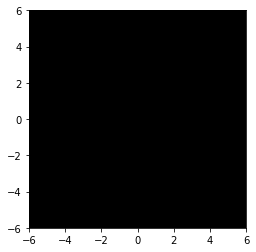

1
[9999]
False True


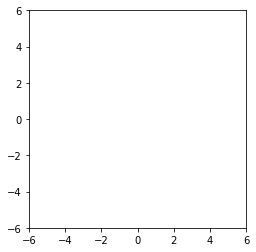

In [2]:
class Electrode:
    '''
    A geometric model of an electrode on the neuropixel shank
    
    Attributes:
    @type samp_rate: float
        the sample rate of the electrodes, given in [Hz]
    @type center: tuple (float, float)
        location of the center of the electrode in cartesian coordinates, given in microns [um]
    @type number: string
        gives the number of the electrode in a string for identification purposes
    
    @type rms: float
        rms cutoff voltage in microvolts [uV]    
    @type activity: int
        is zero when the electrode measures voltages below the rms threshold, is one when measuring voltages above threshold
    @type x: np.array
        numpy array that defines the x-coordinates of the meshgrid describing the electrode
    @type y: np.array
        numpy array that defines the y-coordinates of the meshgrid describing the electrode
    @type activity_meshgrid: np.array
        2d numpy array that shows the electrode activity at every point in the meshgrid describing the electrode
    @type v_readout: list
        each time the electrode's activity is updated, the voltage value is stored in this list
    @type a_readout: list
        each time the electrode's activity is updated, the activity value is stored in this list
    '''
    
    def __init__(self, samp_rate, center, number):
        self.samp_rate = samp_rate
        self._center = center #location of the center of the electrode in um
        self.number = number #numbering system for electrodes
       
        #derived/generated qualities
        self.rms = np.random.choice(RMS_threshold) #rms cutoff voltage in uV
        self._activity = 0 
        self.x = np.round(np.linspace(self._center[0]-6, self._center[0]+6, int(12/0.1) + 1, endpoint = True), 1) #Electrode dim is 12 um
        self.y = np.round(np.linspace(self._center[1]-6, self._center[1]+6, int(12/0.1) + 1, endpoint = True), 1) #Want step size of 0.1
        self.activity_meshgrid = self._activity*np.ones((len(self.x), len(self.y)))
        self.v_readout = []
        self.a_readout = []
        
    
    
    @property
    def center(self):
        return self._center
    
    
    
    @center.setter
    def center(self, center):
        self._center = center 
        
        
        
    @property
    def activity(self):
        return self._activity
    
    
    
    #set electrode activity and update voltage readout
    @activity.setter
    def activity(self, voltage):
        #set activity
        if voltage >= self.rms:
            self._activity = 1
        else: 
            self._activity = 0
            
        #append to voltage/activity readouts
        self.v_readout.append(voltage)
        self.a_readout.append(self._activity)
        self.activity_meshgrid = self._activity*np.ones((len(self.x), len(self.y))) #update activity_meshgrid
            
    
    
    #given X, Y coordinates, return boolean value indicating whether or not the coordinates lie on the array
    def on_electrode(self, x, y):
        if x > self.x[0] and x < self.x[-1] and y > self.y[0] and y < self.y[-1]:
            return True
        else: 
            return False
            
        
        
    #contour plot electrode activity
    def plot_electrode(self):
        plt.contourf(self.x, self.y, self.activity_meshgrid, vmin = -1, vmax = 1, cmap = cmap)
        plt.axis('scaled')
        plt.show()
        
    
    
    #Plot the voltage at the electrode as a function of time
    def readout(self, ax, tvec):
        ax.set_xlabel("Time [s]", fontweight = "bold", fontsize = 15)
        ax.set_ylabel(r"Voltage [$\mu$V]", fontweight = "bold", fontsize = 15)
        ax.set_title("Electrode " + self.number , fontweight = "bold", fontsize = 25)
        
        #Vertical lines indicating when sampling occurs
        samp_lines = np.arange(tvec[0], tvec[-1], 1/self.samp_rate)
        for line in samp_lines:
            ax.axvline(x = line, c = 'red')
        
        #Horizontal line indicated voltage threshold
        threshold = np.ones(len(tvec))
        ax.plot(tvec, threshold * self.rms, linestyle = 'dashed', color = "black")
        
        #Plotting electrode reading
        subplot = ax.plot(tvec, self.v_readout)
        
        return subplot
    
    
    
    #Reset the electrode and clear it's activity and voltage reading
    def reset(self):
        self.v_readout = []
        self.a_readout = []
        
        
    
'''
Example Usage
'''
#define E_1, an Electrode object centered at (0,0) with a 30kHz sample rate
E_1 = Electrode(samp_rate = 30000, center = (0,0), number = "1")
print(E_1.activity) #it's innately initialized to be inactive

E_1.plot_electrode() #plot inactive electrode

#initialize a voltage above the voltage threshold 
E_1.activity = 9999
print(E_1.activity)
print(E_1.v_readout)
print(E_1.on_electrode(-8, 3), E_1.on_electrode(2,-3))

E_1.plot_electrode() #plot active electrode

**Neuron Class**

The wormlike chain algorithm for the neuron is based on a discretized version of the original Kratky-Porod model of a continuous semiflexible polymer. The algorithm is first described in [Schellman, J. A., “Flexibility of DNA,” Biopolymers 13, 217-226 (1974)](https://onlinelibrary.wiley.com/doi/abs/10.1002/bip.1974.360130115) and was therein referred to as the random $\phi$
 model. In this model, the chain is approximated as a series of discrete segments of equal length. In spherical coordinates, the change in direction between successive segments is described by two angles: the zenith angle $\theta$ and the azimuthal angle $\phi$. The azimuthal angle is allowed to vary randomly and uniformly between $0$ and $2\pi$. The zenith angle is a random number whose probability distribution function reflects the rigidty of the polymer and is related to the persistence length.
 
The probability distribution for the zenith angle is derived by considering the change in energy $E_i$ between segments $i$ and $i + 1$ to be only a function of the angle $\theta_i$ between segments. Using a Taylor series expansion about $\theta_i = 0$, we can write $E_i$ as
$$E_i(\theta_i) = E_i(0) + \left. \frac{d E_i}{d \theta_i}\right|_{\theta_i =0} \theta_i + \left.\frac{1}{2!}\frac{d^2 E_i}{d^2 \theta_i^2}\right|_{\theta_i =0} \theta_i^2 + ...$$

At equilibrium, we can set the first derivative equal to zero. Additionally, the change in energy due to bending for two segments which are completely aligned is zero. Thus, neglecting higher order terms, we can write

$$ E_i(\theta_i) \approx \left.\frac{1}{2!}\frac{d^2 E_i}{d^2 \theta_i^2}\right|_{\theta_i =0} \theta_i^2 $$

Using Boltzmann statistics, we can obtain a probability function for the zenith angle $\theta$. It needs to be weighted by a factor of $\sin(\theta)$ in order to reflect that integration over all possible bending angles is $d\Omega = \sin(\theta) d\theta d\phi$.

$$P(\theta) = \frac{1}{Z} \exp\left[-\frac{E_i''(0) \theta^2}{2K_bT} \right] \sin(\theta)$$

However, since we are only considering small angles, it is a reasonable approximation to allow $\sin(\theta) \approx \theta$. Then, the normalization constant is given by allowing the partition function to become continuous. We can make the integral tractable by allowing the bounds to go from zero to infinity. In doing so, we approximate that the contributions to the probability from such large bend angles is negligible because in practice, these angles are extremely unlikely.

$$\begin{align}
Z &= \sum_i^\infty \exp\left[-\frac{E_i''(0) \theta_i^2}{2K_bT} \right] \theta_i\\
a &\equiv \frac{E_i''(0)}{K_bT} \\
Z &= \int_0^\infty \theta \exp \left[\frac{-a\theta^2}{2} \right] d\theta \\
Z &= \frac{1}{a} \\
P(\theta) &= a \exp \left[\frac{-a\theta^2}{2} \right] \theta \\
\end{align}$$

However, this just tells us that the probability distribution for the zenith angle is given by a rayleigh distribution with $\sigma = \frac{1}{a}$.
$$R(x) = \frac{x}{\sigma^2} e^{-x^2/2\sigma^2}$$

Using this probability distribution, the characteristic Flory Ratio $C_\infty$ for an infinite number of steps can be calculated to be 

$$C_\infty = \frac{l}{1-L(a)} $$

where $L(a)$ is the Langevin function. For large enough $a$, the Langevin function $L(x) \approx \frac{1}{x}$. Thus, using the fact that the Flory ratio for an infinite number of steps is an alternate definition of the persistence length $l_p$, we see that $a = \frac{l_p}{l}$. Thus, we can write the final probability distribution for the zenith angle as the rayleigh distribution with $\sigma^2 = \frac{l}{l_p}$. This gives us the following probability distribution for the zenith angle:

$$P(\theta) = \theta \frac{l_p}{l} \exp \left[\frac{-l_p\theta^2}{2l} \right] $$

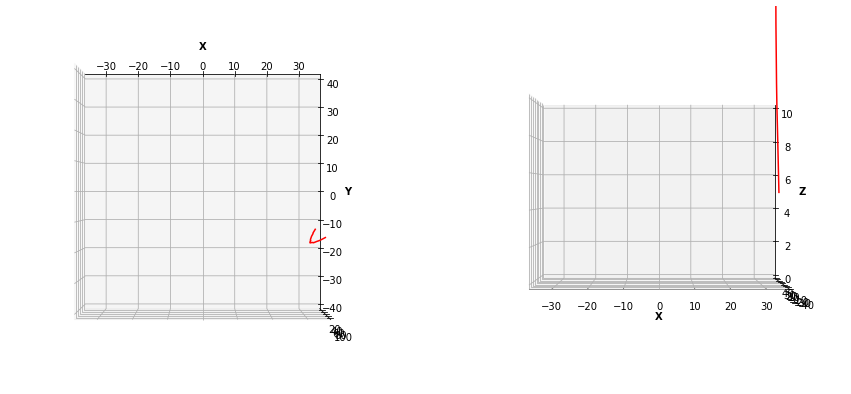

In [3]:
class Neuron: 
    '''
    A self-generating model of a neuron complete with the ability to fire an action potential. 
    It assumes that it is given a starting point on the y-axis.
    
    Attributes: 
    @type samp_rate: float
        the rate at which the neuropixel shank samples it's electrodes
    @type origin: tuple (float, float, float)
        location of the origin of neuron generation in cartesian coordinates (x, y, z) given in microns [um]
    @type bounding: tuple (float, float, float, float)
        location of the boundaries of generation (x_min, x_max, y_min, y_max, z_min) given in microns [um]
    @type persist_len: float
        the length at which angles between tangent vectors become uncorrelated, given in microns [um]
    @type resolution: float
        how many equally spaced steps will be included per sample (related to the sample rate) when growing the neuron, unitless quantity
   
    @type theta: float
        the initial center of the distribution for the azimuthal angle, given in radians [rad]
    @type phi: float
        the initial center of the distribution for the polar angle, given in radians [rad]
    @type grow: bool
        flag to determine whether the neuron should keep growing during neuron generation
    @type action_potential: float
        the strength of action potentials fired by this neuron, given in microvolts [uV]
    @type pulse_speed: float
        the speed of action potentials fired by this neuron, given in microns per second [um/sec]
    @type Lambda: float
        defining length of each step so that time bins are 100 times smaller than the sample rate, given in microns [um]
    @type direction: int
        parameter to ensure rho goes in the correct direction based on which boundary it originates
    @type x_steps: np.array
        an array containing the generated x_values of the neuron in microns [um]
    @type y_steps: np.array
        an array containing the generated y_values of the neuron in microns [um]
    @type z_steps: np.array
        an array containing the generated z_values of the neuron in microns [um]
    @type spatial_voltage: np.array
        an array containing the voltage of the action potential at each point in space due to exponential decay in microvolts [uV]
    @type decay_constant: float
        the value of the spatial decay constant of L5 pyramidal neurons, given in microns [um]
    @type tvec: np.array
        an array with the time when the action potential peak is at the corresponding x/y/z step index, given in seconds [sec]
    '''
    
    def __init__(self, samp_rate, origin, bounding, persist_len=1000, resolution = 100):
        self.samp_rate = samp_rate #Sampling rate of the neuropixel shank, [Hz]
        self.origin = origin #origin located on the y axis, [um]
        self.bounding = bounding #bounding given in [um]
        self.persist_len =  persist_len #persistence length of a neuron [um]
        self.resolution = resolution #resolution of neuron growth, unitless
        
        #derived/generated neuron properties
        self.theta = np.random.uniform(0, np.pi) # [rad]
        self.grow = True 
        self.action_potential = np.random.uniform(20,500) #pulse voltage [uV], range of spike values from recording used to generate 5rms thresholds 
        self.pulse_speed = np.random.uniform(500000,2000000) #neuron pulse speed [um/sec], doi: 10.1152/jn.00628.2014
        self.Lambda = self.pulse_speed/(100*self.samp_rate) #single step length [um]
        self.x_steps = [self.origin[0]] # [um]
        self.y_steps = [self.origin[1]] # [um]
        self.z_steps = [self.origin[2]] # [um]
        self.spatial_voltage = [self.action_potential] # [uV]
        self.decay_constant = 455 # spatial decay contstant [um], taken from: https://doi.org/10.1038/nature04720 
        self.tvec = [0] # [sec]
        
        
        #It is assumed that the origin of the neuron will be placed at either y_min or y_max on the neuron boundary
        if self.origin[0] == self.bounding[0]:
            #if placed at x_min, dx should initially be positive
            self.phi = np.random.uniform(-np.pi/2, np.pi/2) # [rad]
        elif self.origin[0] == self.bounding[1]:
            #if placed at x_max, dx should initially be negative
            self.phi = np.random.uniform(np.pi/2, 3*np.pi/2) # [rad]
        else:
            raise Exception("X coordinate of the origin of the neuron should equal either x_min or x_max in bounding")
            
        #After defining all parameters, the neuron should generate
        self.generate_neuron()

        
        
    #based on initial starting point, generate a step size and angle, then return the ending starting point
    def gen_len_step(self, x_i, y_i, z_i, t_i, v_i):
        #theta_r and phi_r are with respect to the r_hat, phi_hat, theta_hat coordinate system relating to the previous step
        theta_r =  np.random.rayleigh(scale = np.sqrt(self.Lambda/self.persist_len))
        phi_r = np.random.uniform(0, 2*np.pi)  # [rad]
        
        #to get increment in polar angles, use polar relationship between r_hat coordinate system and polar coordinate system
        dtheta = np.sin(theta_r)*np.cos(phi_r)
        dphi = np.sin(theta_r)*np.sin(phi_r)
        
        #add these angles to the previous step's polar angles
        self.theta = self.theta + dtheta
        self.phi = self.phi + dphi
         
        #convert angle increment to cartesian coordinates 
        dx = self.Lambda*np.sin(self.theta)*np.cos(self.phi)
        dy = self.Lambda*np.sin(self.theta)*np.sin(self.phi)
        dz = self.Lambda*np.cos(self.theta)
        dt = self.Lambda/self.pulse_speed
                
        #increment the neuron
        x_f = x_i + dx
        y_f = y_i + dy
        z_f = z_i + dz
        t_f = t_i + dt
        v_f = v_i*np.exp(-self.Lambda/self.decay_constant)

        
        #check bounds
        if x_f < self.bounding[0]:
            self.grow = False
        elif x_f > self.bounding[1]:
            self.grow = False
        if y_f < self.bounding[2]:
            self.grow = False
        elif y_f > self.bounding[3]:
            self.grow = False
        if z_f < self.bounding[4]:
            z_f = self.bounding[4] #this is a 2d array
        
        return x_f, y_f, z_f, t_f, v_f
    
    
    
    #generate the neuron by iteratively calling self.gen_len_step until the self.grow flag is false
    def generate_neuron(self):
        #unpacking initial points for generation from the origin
        x, y, z = self.origin
        t = 0
        v = self.action_potential
        
        while (self.grow == True):
            #use gen_len_step function to calculate next step
            x_f, y_f, z_f, t_f, v_f = self.gen_len_step(x, y, z, t, v)
            
            #appending each step to their respective lists
            self.x_steps.append(x_f)
            self.y_steps.append(y_f)
            self.z_steps.append(z_f)
            self.tvec.append(t_f)
            self.spatial_voltage.append(v_f)
            
            #reassigning for the next iteration of the loop
            x = x_f
            y = y_f
            z = z_f
            t = t_f
            v = v_f
        
        #Typecasting to np.array since it's a more useful data structure
        self.x_steps = np.array(self.x_steps)
        self.y_steps = np.array(self.y_steps)
        self.z_steps = np.array(self.z_steps)
        self.tvec = np.array(self.tvec)
        self.spatial_voltage = np.array(self.spatial_voltage)
    
    
    
    def plot_neuron(self):
        fig = plt.figure(figsize=(15,7))

        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.plot3D(self.x_steps, self.y_steps, self.z_steps, 'red') 
        ax.set_xlabel("X", fontweight= "bold")
        ax.set_ylabel("Y", fontweight= "bold")
        ax.set_xlim(self.bounding[0], self.bounding[1])
        ax.set_ylim(self.bounding[2],self.bounding[3])
        ax.view_init(90, 270)

        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.plot3D(self.x_steps, self.y_steps, self.z_steps, 'red') 
        ax.set_xlabel("X", fontweight= "bold")
        ax.set_zlabel("Z", fontweight= "bold")
        ax.set_xlim(self.bounding[0], self.bounding[1])
        ax.set_ylim(self.bounding[2],self.bounding[3])
        ax.set_zlim(self.bounding[4], 10)
        ax.view_init(0, -90)
         
    
    
'''
Example Usage
'''
#defining neuron characteristics
samp_rate = 30000 #[Hz]
x = np.random.choice([-35, 35])
y = np.random.uniform(-16,16)
z = np.random.uniform(0,5)
origin = (x, y, z) #x, y, z [um]
bounding  = (-35, 35, -40, 40, 0)

N = Neuron(samp_rate, origin, bounding, persist_len = 1000)
N.plot_neuron()

### **Neuropixel Shank Class**

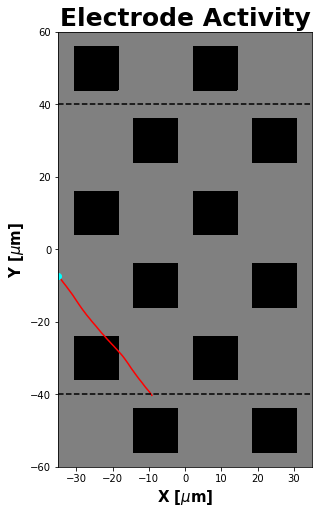

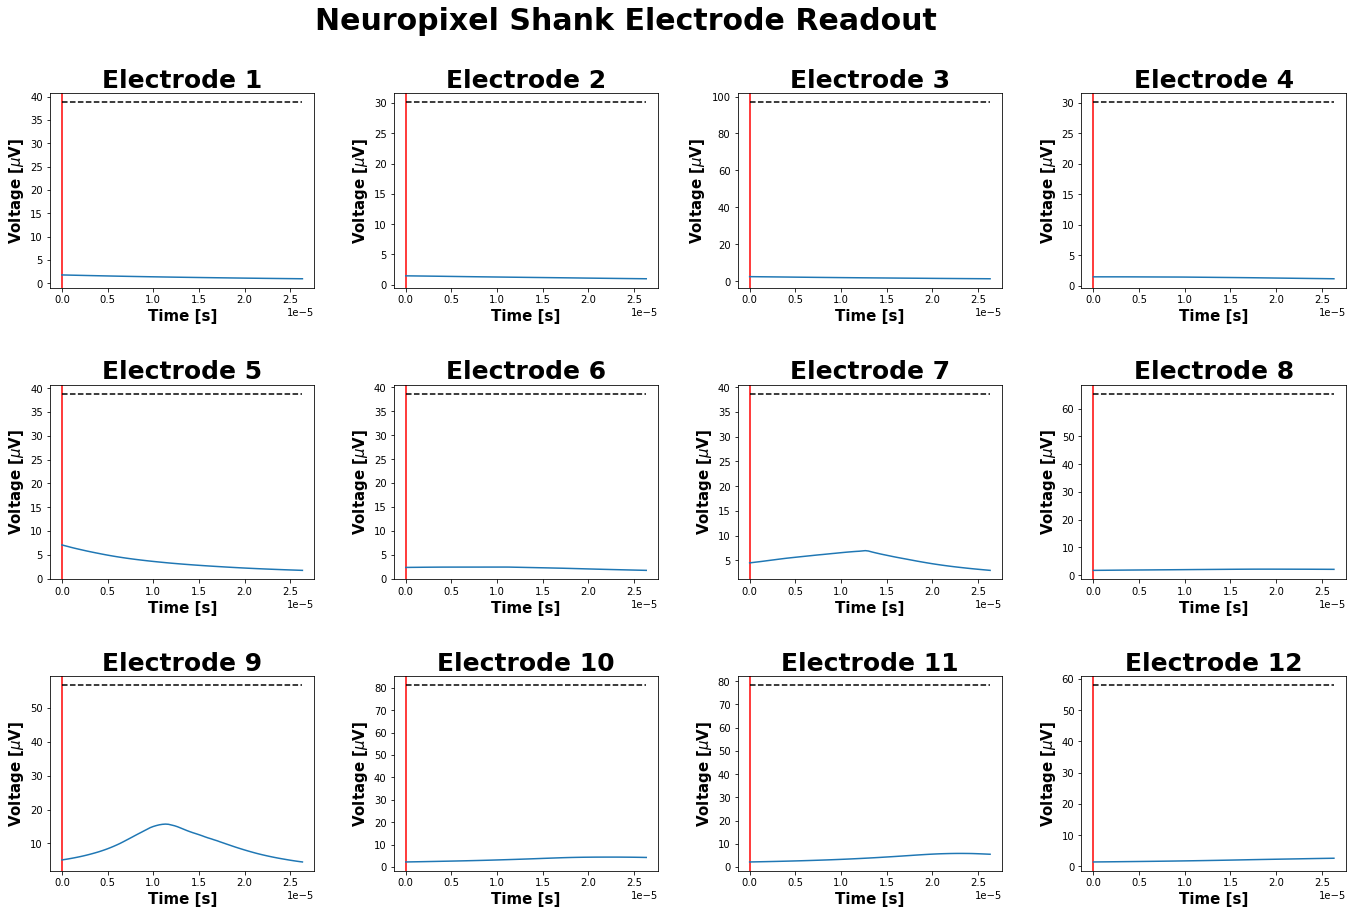

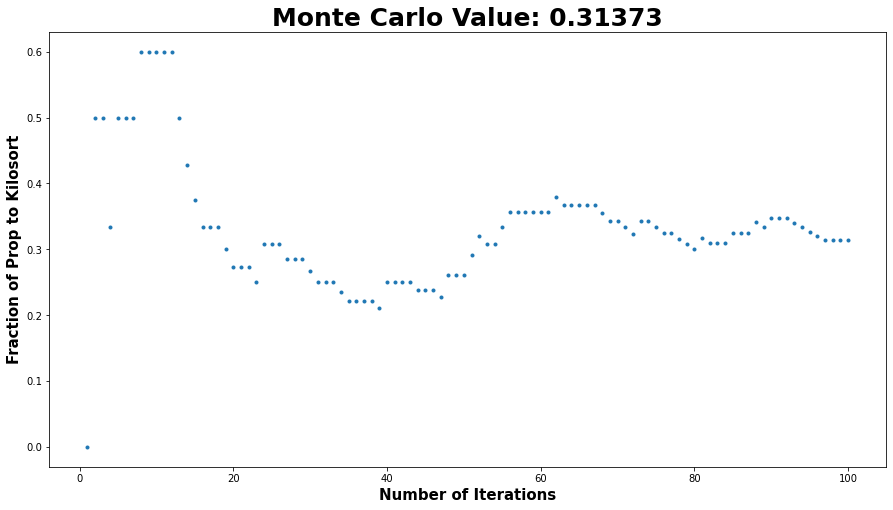

In [42]:
class Neuropixel_Shank:
    '''
    A geometric model of the neuropixel shank that combines electrode readout functionality with an in vitro neuron
    
    Attributes: 
    @type samp_rate: float
        sample rate [Hz]
    @type persist_len: float
        the length at which angles between tangent vectors in the neuron become uncorrelated, given in microns [um]
        
    @type num_E: int
        the number of electrodes in the neuropixel shank
    @type Electrode_1-12: Electrode
        electrode object that comprises the neuropixel shank
    @type Shank: list[Electrode, Electrode,...,Electrode]
        list containing each electrode in the neuropixel shank for easy iteration
    
    @type x: np.array
        numpy array that defines the x-coordinates of the meshgrid describing the neuropixel shank
    @type y: np.array
        numpy array that defines the y-coordinates of the meshgrid describing the neuropixel shank
    @type activity_meshgrid: np.array
        2d numpy array that shows the electrode activity at every point in the meshgrid describing the neuropixel shank
    @type time_bin_indices: list
        A list containing the indices in the Neuron's tvec array at which the voltage at each electrode would be sampled at the current samp_rate
    '''
    
    def __init__(self, samp_rate, persist_len = 1000):
        self.samp_rate = samp_rate #Hz
        self.persist_len = persist_len # um
        
        #initializing neuron placeholder, needs to be generated in separate function
        self.tissue = None #Neuron object
        
        #initializing electrode array (I hardcoded the electrode locations because the neuropixel is static)
        self.num_E = 12
        self.Electrode_1 = Electrode(self.samp_rate, (-24.6,50), "1")
        self.Electrode_2 = Electrode(self.samp_rate, (8.2,50), "2")
        self.Electrode_3 = Electrode(self.samp_rate, (-8.2,30), "3")
        self.Electrode_4 = Electrode(self.samp_rate, (24.6,30), "4")
        self.Electrode_5 = Electrode(self.samp_rate, (-24.6,10), "5")
        self.Electrode_6 = Electrode(self.samp_rate, (8.2,10), "6")
        self.Electrode_7 = Electrode(self.samp_rate, (-8.2,-10), "7")
        self.Electrode_8 = Electrode(self.samp_rate, (24.6,-10), "8")
        self.Electrode_9 = Electrode(self.samp_rate, (-24.6,-30), "9")
        self.Electrode_10 = Electrode(self.samp_rate, (8.2,-30), "10")
        self.Electrode_11 = Electrode(self.samp_rate, (-8.2,-50), "11")
        self.Electrode_12 = Electrode(self.samp_rate, (24.6,-50), "12")
        self.Shank = [self.Electrode_1, self.Electrode_2, self.Electrode_3, self.Electrode_4, self.Electrode_5, self.Electrode_6, self.Electrode_7, self.Electrode_8, self.Electrode_9, self.Electrode_10, self.Electrode_11, self.Electrode_12]
        
        #shank geometry
        self.x = np.round(np.linspace(-35, 35, int(70/0.1)+1, endpoint=True), 1)
        self.y = np.round(np.linspace(-60, 60, int(120/0.1)+1, endpoint = True), 1)
        self.activity_meshgrid = -1*np.ones((len(self.y), len(self.x))) #setting nonelectrode area to -1 activity
        
        #setup stuff for animation
        self.fig = None
        self.ax = None
        
        
        #time bin indices for monte carlo analysis
        self.time_bin_indices = []
        
        #Generate and fire Neuron upon initialization
        self.gen_neuron()
        self.fire_neuron()

    
    
    #Generate a neuron and update self.tissue with it
    def gen_neuron(self):
        #randomly generate the origin from an x-boundary, the middle two electrodes in y, and random z near the shank
        x = np.random.choice([-35, 35])
        y = np.random.uniform(-16,16)
        z = np.random.uniform(0,10)
        origin = (x, y, z) #x, y, z [um]
        bounding  = (-35, 35, -40, 40, 0)
        
        #update self.tissue with the neuron
        self.tissue = Neuron(self.samp_rate, origin, bounding, self.persist_len)
        
        #get discretization of time bins
        time_bins = np.arange(self.tissue.tvec[0], self.tissue.tvec[-1], 1/self.samp_rate )
       
        #get indices where time_bins align with time vector
        for time_bin in time_bins:
            index = np.argmin(np.abs(self.tissue.tvec-time_bin))
            self.time_bin_indices.append(index)
        
    
    
    #Set the potential at each electrode based on the location of the action potential in the neuron as a function of time
    def fire_neuron(self):
        for i in range(len(self.tissue.tvec)):
            for electrode in self.Shank:
                #cartesian position of action potential 
                X = self.tissue.x_steps[i]
                Y = self.tissue.y_steps[i]
                Z = self.tissue.z_steps[i]
                V = self.tissue.spatial_voltage[i]
                
                #logic for determining spatial fall-off of action potential
                if electrode.on_electrode(X, Y) and Z < 1: 
                    #is neuron on the electrode?
                    electrode.activity = V
                elif electrode.on_electrode(X, Y): 
                    #is neuron above the electrode?
                    electrode.activity = V/Z
                else: #neuron is adjacent to an electrode
                    x_cen, y_cen = electrode.center
                    
                    #get distance from electrode to neuron action potential
                    x_elec = np.abs(x_cen - X) 
                    y_elec = np.abs(y_cen - Y)
                    
                    #get correction from center to edge of electrode
                    theta = np.arctan(y_elec/x_elec)
                    if theta <= np.pi/4:
                        d = 6/np.cos(theta)
                    elif theta > np.pi/4:
                        d = 6/np.sin(theta)
                    
                    #Calculate R
                    R = ((x_elec - d*np.cos(theta))**2 + (y_elec - d*np.sin(theta))**2 + (Z)**2)**0.5
                    if R < 1:
                        electrode.activity = V
                    else: 
                        electrode.activity = V/R
                    
                    
                    
    #plot the potential of all the electrodes simultaneously
    def readout(self):       
        fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (20,12))
    
        i = 0
        for ax in np.ravel(axs):
            electrode = self.Shank[i]
            electrode.readout(ax, self.tissue.tvec)
            i += 1
            
        plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1, wspace=0.3, hspace=0.5)
        fig.suptitle('Neuropixel Shank Electrode Readout', fontweight = 'bold', fontsize=30, y = 1.10)

    
    
    #Retrieves the activity level of each electrode and updates the shank activity meshgrid with these values    
    def update_shank_activity(self, frame_num):
        for electrode in self.Shank:
            x = electrode.x
            y = electrode.y
            electrode.activity = electrode.v_readout[frame_num] #setting the activity with the location of action potential
            electrode.v_readout.pop() #removing above from the voltage readout so it doesn't cause length casting issues in readout function
            activity = electrode.activity_meshgrid
            
            #getting x/y indices in the non-flattened array
            x_indices = np.where(np.logical_and(self.x >= x[0], self.x <= x[-1]))[0]
            y_indices = np.where(np.logical_and(self.y >= y[0], self.y <= y[-1]))[0]
            
            #getting indices of the flattened array
            indices = []
            for element in y_indices:
                row = (x_indices + 1) + (element * len(self.x))
                indices.extend(row)
            indices = np.array(indices)
            
            #updating activity of the meshgrid
            np.put(self.activity_meshgrid, indices, activity)
            

            
    #contour plot of shank activity_meshgrid + 2D projection of 3D neuron atop the shank
    def plot_shank(self, frame_num):
        #obtain indices of discretized time bins
        index = frame_num*10
       
        #update shank_activity
        self.update_shank_activity(index)
        
        #Contour Plot
        self.ax.contourf(self.x, self.y, self.activity_meshgrid, vmin = -1, vmax = 1,cmap = cmap)
        self.ax.axis('scaled')
        
        #Neuron Plot
        if self.tissue is not None:
            #plot neuron
            self.ax.plot(self.tissue.x_steps, self.tissue.y_steps, color = 'red')
            
            #plot location of action potential
            self.ax.plot(self.tissue.x_steps[index], self.tissue.y_steps[index], linestyle = '', marker = 'o', color = 'cyan')
            
            #plot boundary lines
            boundary = np.ones(len(self.x))
            self.ax.plot(self.x, boundary * self.tissue.bounding[2], linestyle = 'dashed', color = "black")
            self.ax.plot(self.x, boundary * self.tissue.bounding[3], linestyle = 'dashed', color = "black")
        
        #Labels
        self.ax.set_xlabel(r"X [$\mu$m]", fontweight = "bold", fontsize = 15)
        self.ax.set_ylabel(r"Y [$\mu$m]", fontweight = "bold", fontsize = 15)
        self.ax.set_title("Electrode Activity", fontweight = "bold", fontsize = 25)
        self.ax.set_xlim(-35,35)
        plt.show()
        
        #Returning axis object as "frame"
        frame = self.ax
        
        return frame
            
        
    #Animation of action potential as it translates down the neuron, with electrode activity included
    def animate_shank(self, image = False, frame_num = 0):        
        figure, axis = plt.subplots(figsize = (7,8))
        self.fig = figure
        self.ax = axis
        #Turn plt output off so that the animation goes to the embedded html5 video
        plt.ioff()
        
        #animate and display html5 video
        anim = animation.FuncAnimation(self.fig, self.plot_shank, frames = len(self.tissue.tvec)//10, interval=50) #animate every tenth frame
        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        
        #close animation stream and reenable plt output
        plt.close()
        plt.ion()
        
        #generate still image if requested
        if image == True:
            self.plot_shank(frame_num)
        
        return anim
    
    
    
    #Reset the readings from the entire neuropixel shank
    def full_reset(self):
        #reset electrode
        for electrode in self.Shank:
            electrode.reset()
            
        #reset neurons
        self.time_bin_indices = []
    
    
    
    #determine kilosort + prop detection
    def detection(self):
        #get activity of all electrodes
        tot_activity = np.zeros(len(self.time_bin_indices))
        num_electrodes = 0
        for electrode in self.Shank:
            #for each time bin, append the activity at that point
            activity_bins = []
            for index in self.time_bin_indices:
                sample_bin = electrode.a_readout[index:index + self.tissue.resolution] 
                max_activity = max(sample_bin) 
                activity_bins.append(max_activity)
            
            num_electrodes += max(activity_bins) #if the electrode was active during any of it's bins, max(activity_bins)==1
            tot_activity += np.array(activity_bins) 
        
        #if only one electrode is excited
        if num_electrodes == 1:
            kilosort = 1
            prop = 0
            
        #More than one elctrode is excited
        elif num_electrodes > 1: 
            kilosort = 1
            
            #If the maximum simultaneous electrode activity is 1, then no electrodes overlap in time
            if max(tot_activity) == 1:
                prop = 1
            #check time bin simultaneity 
            elif max(tot_activity) > 1:
                #if the difference in magnitude between two activity time bins is one, they're detected in two time bins and prop detects it
                activity_diff = np.diff(tot_activity) 
                
                #thus if the number of indices where this occurs is greater than zero, prop detects the neuron
                if len(np.where(activity_diff == 1)[0]) > 0:
                    prop = 1
                else: 
                    prop = 0

        else:
            kilosort = 0
            prop = 0

        return kilosort, prop
    
    
    
    #The monte_carlo simulation
    def monte_carlo(self, iterations):
        kilosort = 0 
        prop = 0
        frac_p_k = []
        
        for sim in range(iterations):
            #reset the electrode array
            self.full_reset()
            
            #simulate the neuron
            self.gen_neuron()
            self.fire_neuron()
            kilo, propagation = self.detection()
            
            #update algorithm tally
            kilosort += kilo
            prop += propagation
            
            #If no neuron detected, skip fraction calculation to avoid dividing by zero errors
            if kilosort == 0:
                continue
                
            frac = prop/kilosort
            frac_p_k.append(frac)
        
        return frac_p_k
    
    
    
    #Plot the monte carlo simulation
    def plot_monte_carlo(self, iterations):
        fraction = self.monte_carlo(iterations)
        x_axis = np.array(range(len(fraction))) + 1
        
        plt.figure(figsize = (15,8))
        plt.plot(x_axis, fraction, linestyle = "", marker = ".")
        plt.xlabel("Number of Iterations", fontweight = "bold", fontsize = 15)
        plt.ylabel(r"Fraction of Prop to Kilosort", fontweight = "bold", fontsize = 15)
        plt.title(f"Monte Carlo Value: {fraction[-1]:.5f}", fontweight = "bold", fontsize = 25)
        plt.show()
            
            
      
        
'''
Example Usage
'''
neuropixel = Neuropixel_Shank(samp_rate = 30000, persist_len = 1000)
neuropixel.animate_shank(image = True)
neuropixel.readout()
neuropixel.plot_monte_carlo(100)

# Persistence Length Comparison

Completed Monte Carlo Analysis of Neurons with 100 micron persistence length
Completed Monte Carlo Analysis of Neurons with 250 micron persistence length
Completed Monte Carlo Analysis of Neurons with 500 micron persistence length
Completed Monte Carlo Analysis of Neurons with 1000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 2000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 3000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 4000 micron persistence length
Completed Monte Carlo Analysis of Neurons with 5000 micron persistence length


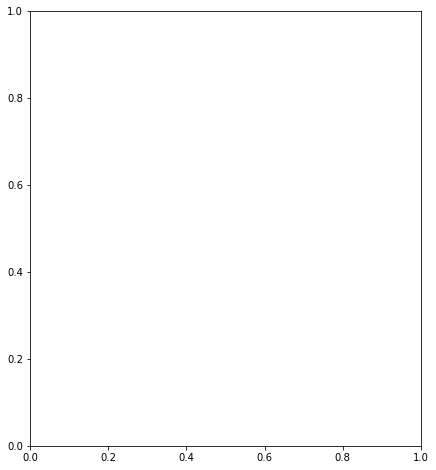

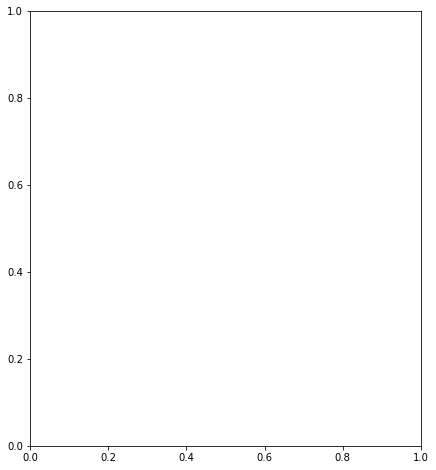

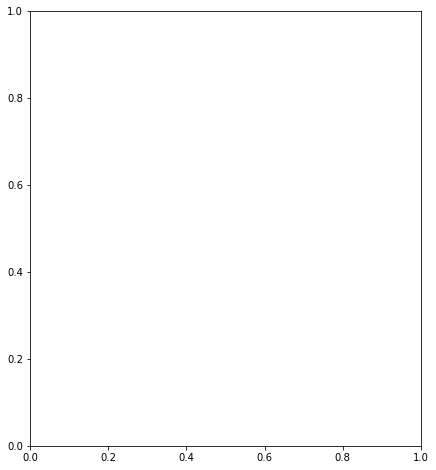

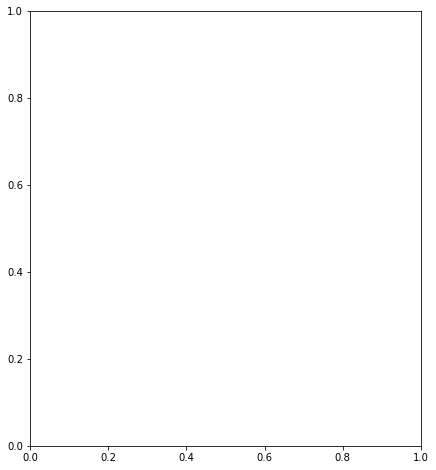

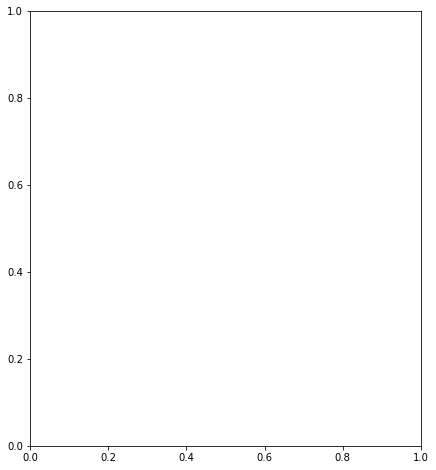

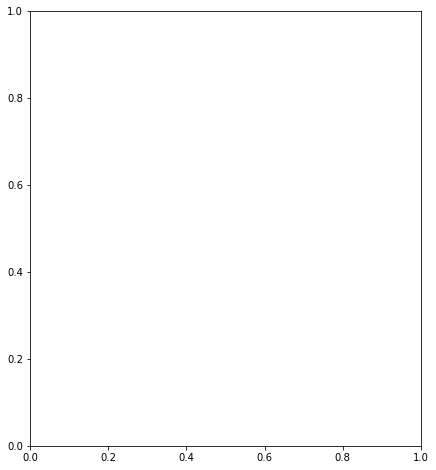

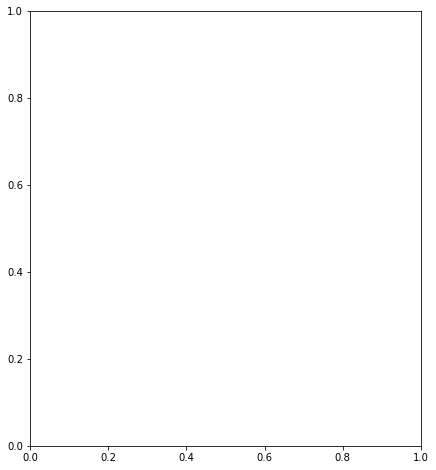

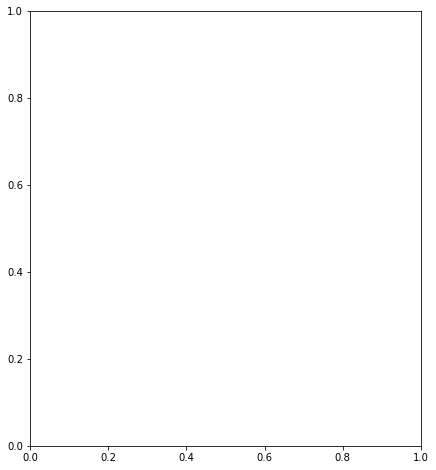

In [49]:
persist_lens = [100,250,500,1000,2000,3000,4000,5000]
fraction = []

for persist_len in persist_lens:
    neuropixel = Neuropixel_Shank(samp_rate = 30000, persist_len = persist_len)
    frac = neuropixel.monte_carlo(1000)
    frac = frac[-1]
    fraction.append(frac)
    print("Completed Monte Carlo Analysis of Neurons with " + str(persist_len) + " micron persistence length")

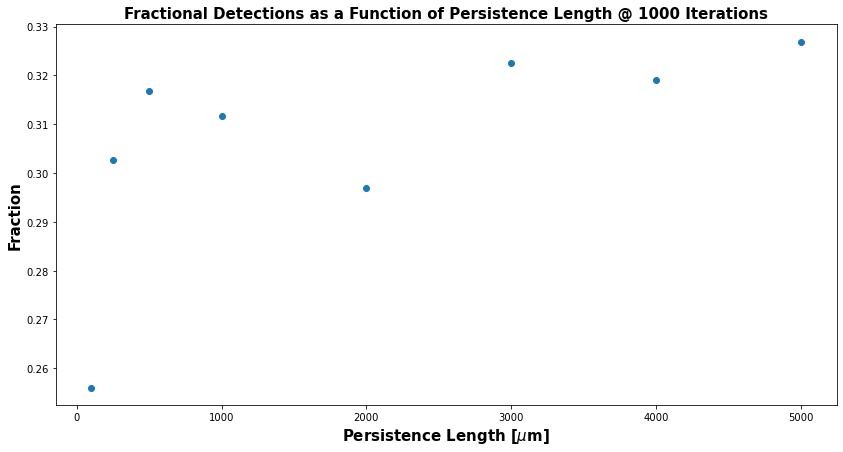

[0.2560553633217993, 0.30275229357798167, 0.31670281995661603, 0.3116531165311653, 0.29691211401425177, 0.3224852071005917, 0.3190883190883191, 0.3269230769230769]


In [51]:
plt.figure(figsize = (14,7))
plt.plot(persist_lens, fraction, linestyle = '', marker = 'o')
plt.xlabel(r"Persistence Length [$\mu$m]", fontweight = "bold", fontsize = 15)
plt.ylabel("Fraction", fontweight = "bold", fontsize = 15)
plt.title("Fractional Detections as a Function of Persistence Length @ 1000 Iterations", fontweight = "bold", fontsize = 15)
plt.show()
print(fraction)